### How to visualise the batches and compare it with model predictions

In [1]:
import torch
from torch.utils.data import DataLoader
from src.bfm.src.dataloder import LargeClimateDataset, custom_collate

In [2]:
dataset = LargeClimateDataset(data_dir="/home/thanasis.trantas/git_projects/bfm-model/data", num_species=2)

viz_dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
    collate_fn=custom_collate,
    drop_last=True,
    shuffle=False,
)
len(viz_dataloader)

1

In [3]:
sample = next(iter(viz_dataloader))
sample

/home/thanasis.trantas/git_projects/bfm-model/src/bfm/src/dataloder.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(fpath, map_location='cpu')


Batch(batch_metadata=Metadata(latitudes=tensor([72.0000, 71.7500, 71.5000, 71.2500, 71.0000, 70.7500, 70.5000, 70.2500,
        70.0000, 69.7500, 69.5000, 69.2500, 69.0000, 68.7500, 68.5000, 68.2500,
        68.0000, 67.7500, 67.5000, 67.2500, 67.0000, 66.7500, 66.5000, 66.2500,
        66.0000, 65.7500, 65.5000, 65.2500, 65.0000, 64.7500, 64.5000, 64.2500,
        64.0000, 63.7500, 63.5000, 63.2500, 63.0000, 62.7500, 62.5000, 62.2500,
        62.0000, 61.7500, 61.5000, 61.2500, 61.0000, 60.7500, 60.5000, 60.2500,
        60.0000, 59.7500, 59.5000, 59.2500, 59.0000, 58.7500, 58.5000, 58.2500,
        58.0000, 57.7500, 57.5000, 57.2500, 57.0000, 56.7500, 56.5000, 56.2500,
        56.0000, 55.7500, 55.5000, 55.2500, 55.0000, 54.7500, 54.5000, 54.2500,
        54.0000, 53.7500, 53.5000, 53.2500, 53.0000, 52.7500, 52.5000, 52.2500,
        52.0000, 51.7500, 51.5000, 51.2500, 51.0000, 50.7500, 50.5000, 50.2500,
        50.0000, 49.7500, 49.5000, 49.2500, 49.0000, 48.7500, 48.5000, 48.2500,


In [ ]:
groups = [
    "surface_variables",
    "single_variables",
    "atmospheric_variables",
    "species_extinction_variables",
    "land_variables",
    "agriculture_variables",
    "forest_variables",
    "species_variables",
    # "batch_metadata"
]
for group_name in groups:

    # pred_dict = sample[group_name]
    true_dict = getattr(sample, group_name)

    for var_name, pred_tensor in true_dict.items():
        sample_tensor = true_dict[var_name]
        print(sample_tensor.shape)


torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 3, 152, 320])
torch.Size([1, 2, 3, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 152, 320])
torch.Size([1, 2, 2, 152, 320])


AttributeError: 'Metadata' object has no attribute 'items'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [6]:
def plot_timesteps_and_difference(var_name, sample_tensor, channel_idx=None):
    """
    Plots three maps side-by-side:
      1. Timestep 1 of the variable.
      2. Timestep 2 of the variable.
      3. The difference (Timestep 2 - Timestep 1).
    
    Parameters:
      var_name (str): Name of the variable (used in plot titles).
      sample_tensor (torch.Tensor): Tensor with shape either 
            [batch_size, 2, 152, 320] (no channel) or
            [batch_size, 2, channels, 152, 320] (with channel).
      channel_idx (int, optional): If tensor has a channel dimension, this selects which channel to plot.
                                   Defaults to 0.
    """
    # Ensure tensor is on CPU and convert to numpy array
    tensor_np = sample_tensor.cpu().numpy()
    
    # Extract data for timestep 1 and timestep 2:
    if tensor_np.ndim == 4:
        # Shape: [batch_size, 2, lat, lon]
        t1 = tensor_np[0, 0, :, :]  # timestep 1
        t2 = tensor_np[0, 1, :, :]  # timestep 2
        lon = tensor_np[0, 0, 0, :]
        lat = tensor_np[0, 0, :, 0]
    elif tensor_np.ndim == 5:
        # Shape: [batch_size, 2, channel, lat, lon]
        if channel_idx is None:
            channel_idx = 0  # default to first channel
        t1 = tensor_np[0, 0, channel_idx, :, :]
        t2 = tensor_np[0, 1, channel_idx, :, :]
        lon = tensor_np[0, 0, 0, 0, :]
        lat = tensor_np[0, 0, 0, :, 0]
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor_np.shape}")
    
    # Compute difference between timestep 2 and timestep 1.
    diff = t2 - t1

    # Create coordinate arrays based on the spatial dimensions.
    # We assume the spatial grid is 152x320.
    # Longitude is in the range 0-360; latitude is assumed to span -90 to 90.
    # print(lon, lat)
    # lon = tensor_np[-1]
    # lat = tensor_np[-2]
    Lon, Lat = np.meshgrid(lon, lat)
    
    # Create a figure with 3 subplots (side-by-side)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot Timestep 1
    ax = axes[0]
    ax.coastlines(resolution='110m')
    cf1 = ax.contourf(Lon, Lat, t1, levels=60, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.set_title(f"{var_name} - Timestep 1")
    fig.colorbar(cf1, ax=ax, orientation='vertical', label="Value")
    
    # Plot Timestep 2
    ax = axes[1]
    ax.coastlines(resolution='110m')
    cf2 = ax.contourf(Lon, Lat, t2, levels=60, transform=ccrs.PlateCarree(), cmap='viridis')
    ax.set_title(f"{var_name} - Timestep 2")
    fig.colorbar(cf2, ax=ax, orientation='vertical', label="Value")
    
    # Plot the Difference (Timestep 2 - Timestep 1)
    ax = axes[2]
    ax.coastlines(resolution='110m')
    cf_diff = ax.contourf(Lon, Lat, diff, levels=60, transform=ccrs.PlateCarree(), cmap='RdBu_r')
    ax.set_title(f"{var_name} - Difference (T2 - T1)")
    fig.colorbar(cf_diff, ax=ax, orientation='vertical', label="Difference")
    
    plt.tight_layout()
    plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import torch

def plot_europe_timesteps_and_difference(var_name, tensor, channel_idx=None):
    """
    Given a tensor with shape either:
      - [batch, 2, lat, lon]  OR
      - [batch, 2, channel, lat, lon],
    this function extracts data for timestep 1 and timestep 2 and computes the difference.
    
    Instead of using coordinates extracted from the tensor, we use fixed coordinate arrays:
      - Latitude: 152 values starting at 72.0000 and decreasing by 0.25 down to 34.2500.
      - Longitude: 320 values linearly spaced from -30.0000 to 40.0000.
      
    Three subplots are then created over Europe using Cartopy.
    
    Parameters:
      var_name (str): Name of the variable (used in plot titles).
      tensor (torch.Tensor): Input tensor.
      channel_idx (int, optional): For 5D tensors, index of the channel to plot.
    """
    tensor_np = tensor.cpu().numpy()
    
    # Extract data slices from the tensor
    if tensor_np.ndim == 4:
        # Shape: [batch, 2, lat, lon]
        t1 = tensor_np[0, 0, :, :]
        t2 = tensor_np[0, 1, :, :]
    elif tensor_np.ndim == 5:
        # Shape: [batch, 2, channel, lat, lon]
        if channel_idx is None:
            channel_idx = 0
        t1 = tensor_np[0, 0, channel_idx, :, :]
        t2 = tensor_np[0, 1, channel_idx, :, :]
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor_np.shape}")
    
    # Compute the difference between timestep 2 and timestep 1
    diff = t2 - t1
    
    # Create fixed coordinate arrays:
    # Latitude: starting at 72.0000, decrement by 0.25 for 152 points.
    lat_fixed = np.linspace(72, 34.25, 152)
    # For plotting, it's common to have latitudes in ascending order.
    lat_fixed = np.sort(lat_fixed)  # now from 34.25 to 72.00
    
    # Longitude: 320 values linearly spaced from -30.0000 to 40.0000.
    lon_fixed = np.linspace(-30, 40, 320)
    
    # Create a coordinate meshgrid with indexing='xy'
    Lon, Lat = np.meshgrid(lon_fixed, lat_fixed, indexing='xy')
    print("Using fixed coordinate grid:")
    print("Latitude range:", lat_fixed[0], "to", lat_fixed[-1])
    print("Longitude range:", lon_fixed[0], "to", lon_fixed[-1])
    print("Meshgrid shapes: Lon:", Lon.shape, "Lat:", Lat.shape)
    
    # Define the Europe bounding box (for setting plot extent)
    europe_extent = [-30, 40, 34.25, 72]  # [lon_min, lon_max, lat_min, lat_max]
    
    # Create a figure with 3 subplots using Cartopy PlateCarree projection.
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot Timestep 1
    ax = axes[0]
    ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
    try:
        ax.coastlines(resolution='50m')
    except Exception as e:
        print("Error drawing coastlines on Timestep 1:", e)
    cf1 = ax.contourf(Lon, Lat, t1, levels=60, cmap='viridis', transform=ccrs.PlateCarree())
    ax.set_title(f"{var_name} - Timestep 1")
    fig.colorbar(cf1, ax=ax, orientation='vertical', label="Value")
    
    # Plot Timestep 2
    ax = axes[1]
    ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
    try:
        ax.coastlines(resolution='50m')
    except Exception as e:
        print("Error drawing coastlines on Timestep 2:", e)
    cf2 = ax.contourf(Lon, Lat, t2, levels=60, cmap='viridis', transform=ccrs.PlateCarree())
    ax.set_title(f"{var_name} - Timestep 2")
    fig.colorbar(cf2, ax=ax, orientation='vertical', label="Value")
    
    # Plot Difference (Timestep 2 - Timestep 1)
    ax = axes[2]
    ax.set_extent(europe_extent, crs=ccrs.PlateCarree())
    try:
        ax.coastlines(resolution='50m')
    except Exception as e:
        print("Error drawing coastlines on Difference plot:", e)
    cf_diff = ax.contourf(Lon, Lat, diff, levels=60, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.set_title(f"{var_name} - Difference (T2 - T1)")
    fig.colorbar(cf_diff, ax=ax, orientation='vertical', label="Difference")
    
    plt.tight_layout()
    plt.show()


Plotting surface_variables:t2m with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


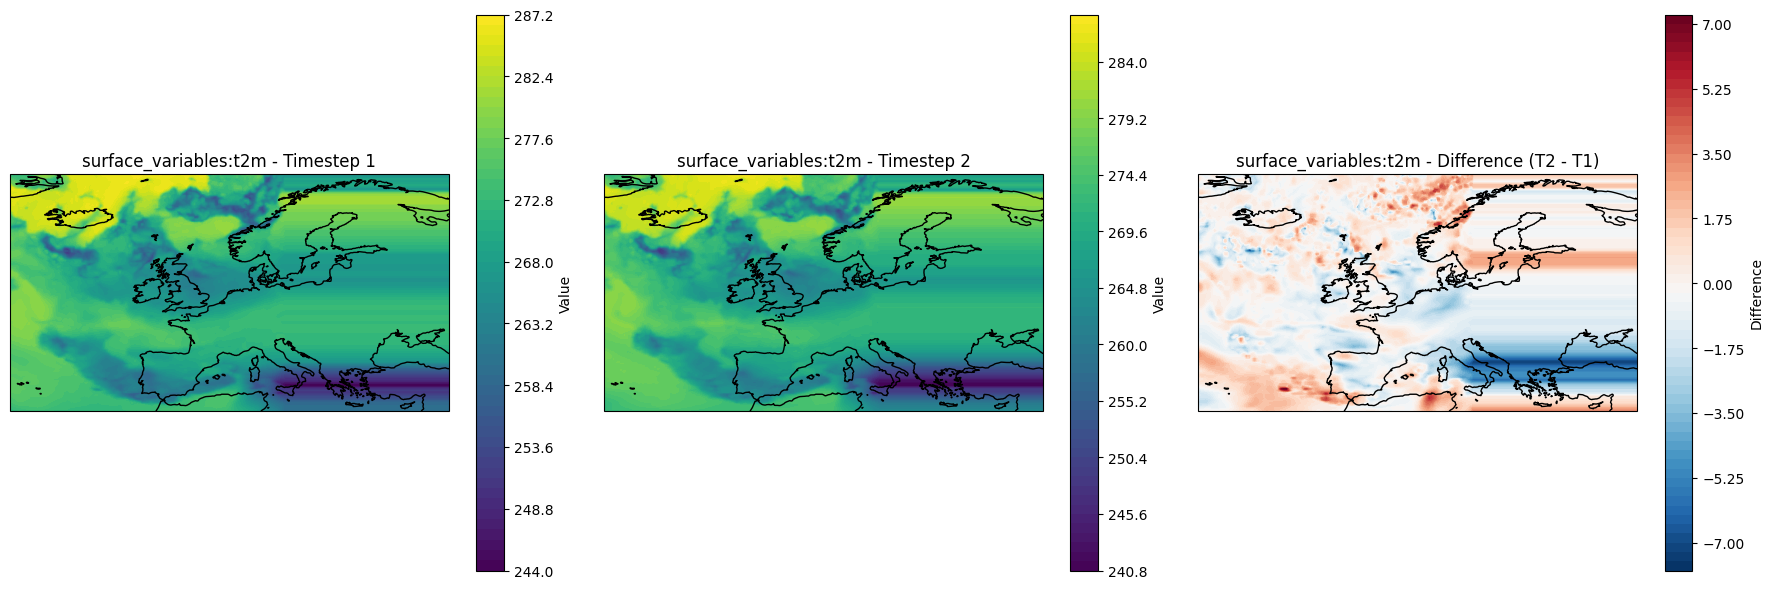

Plotting surface_variables:msl with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


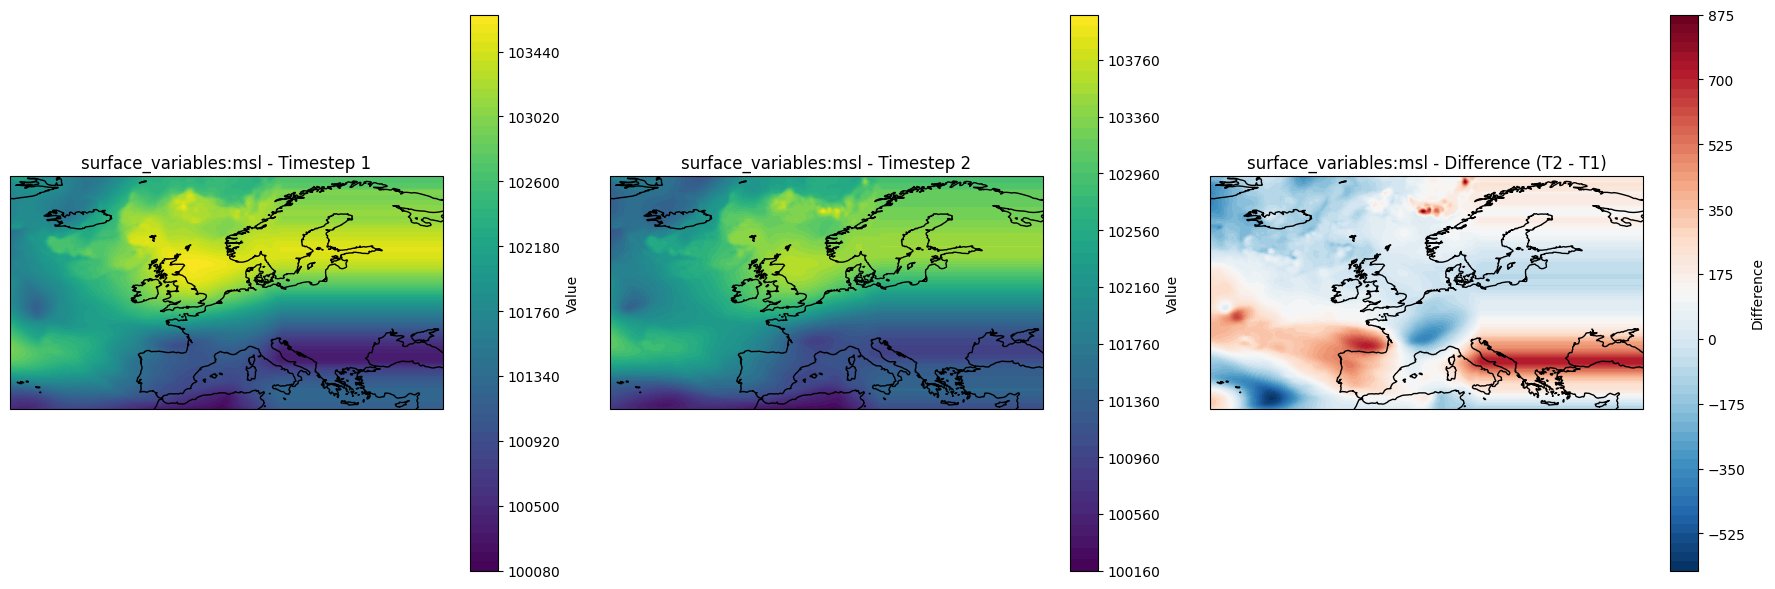

Plotting single_variables:lsm with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


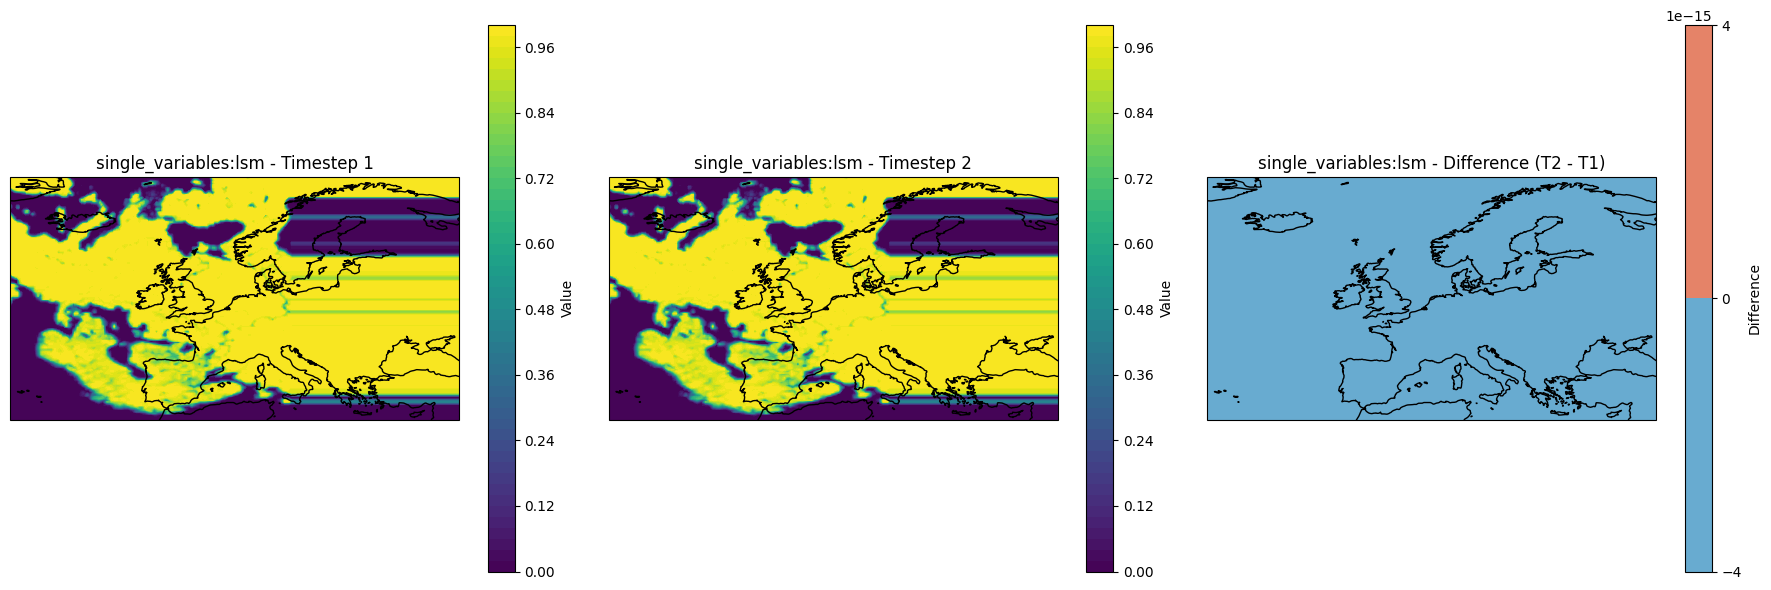

Plotting atmospheric_variables:z with shape torch.Size([1, 2, 3, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


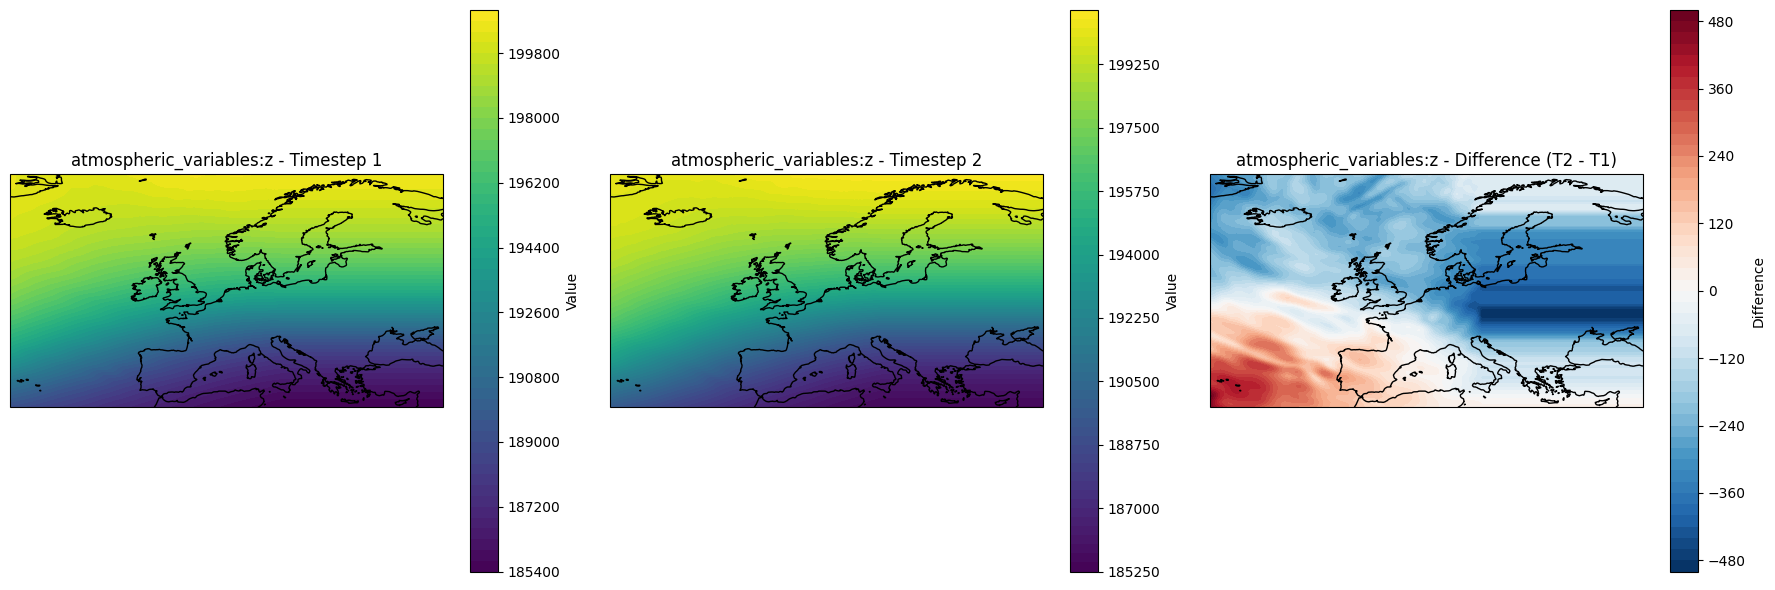

Plotting atmospheric_variables:t with shape torch.Size([1, 2, 3, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


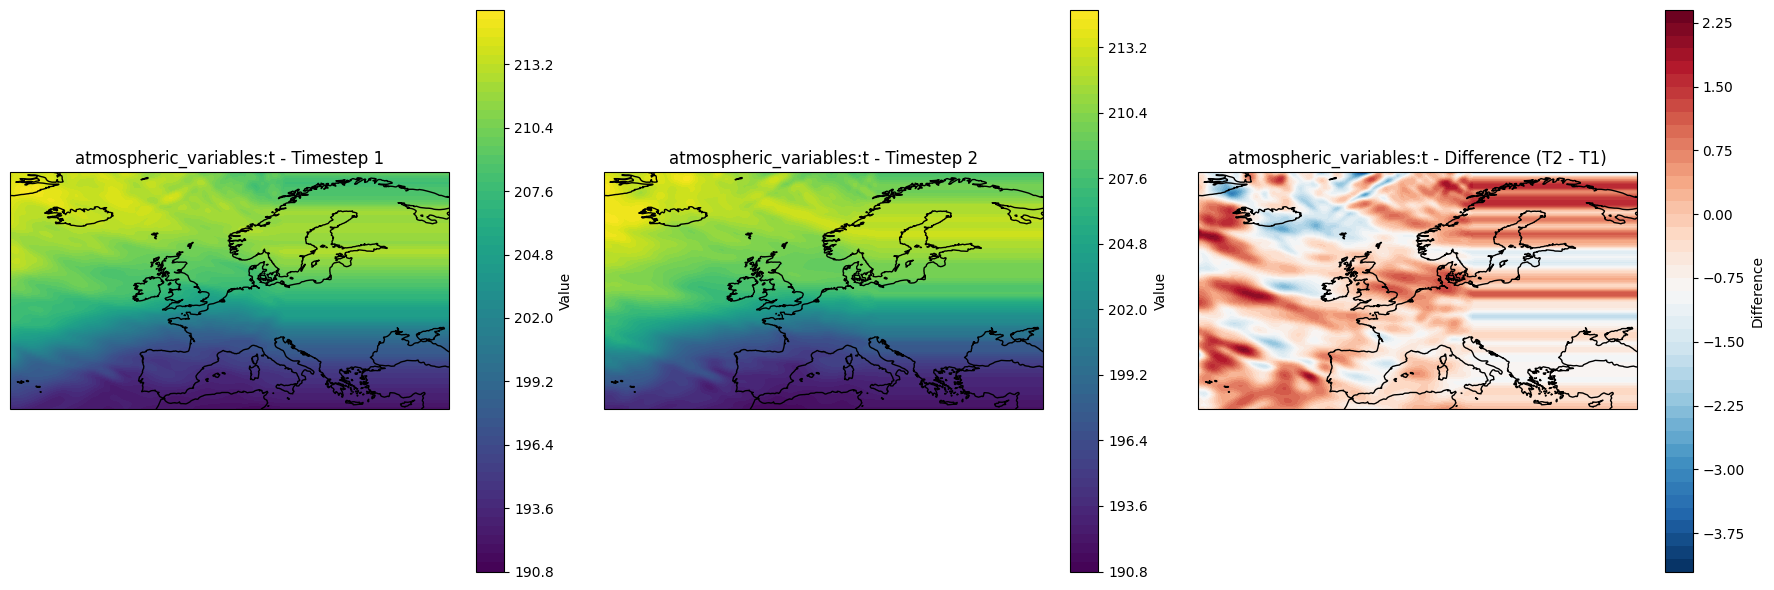

Plotting species_extinction_variables:ExtinctionValue with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


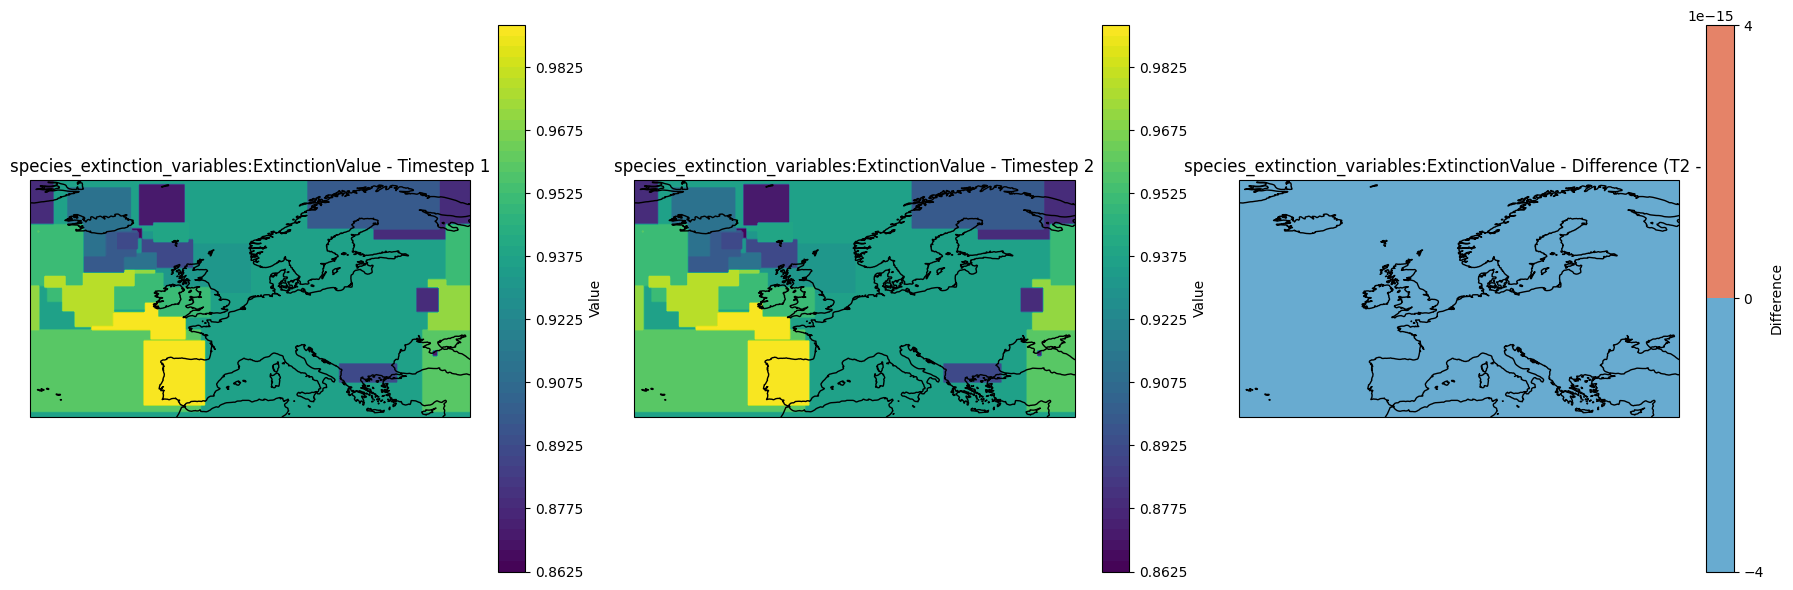

Plotting land_variables:Land with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


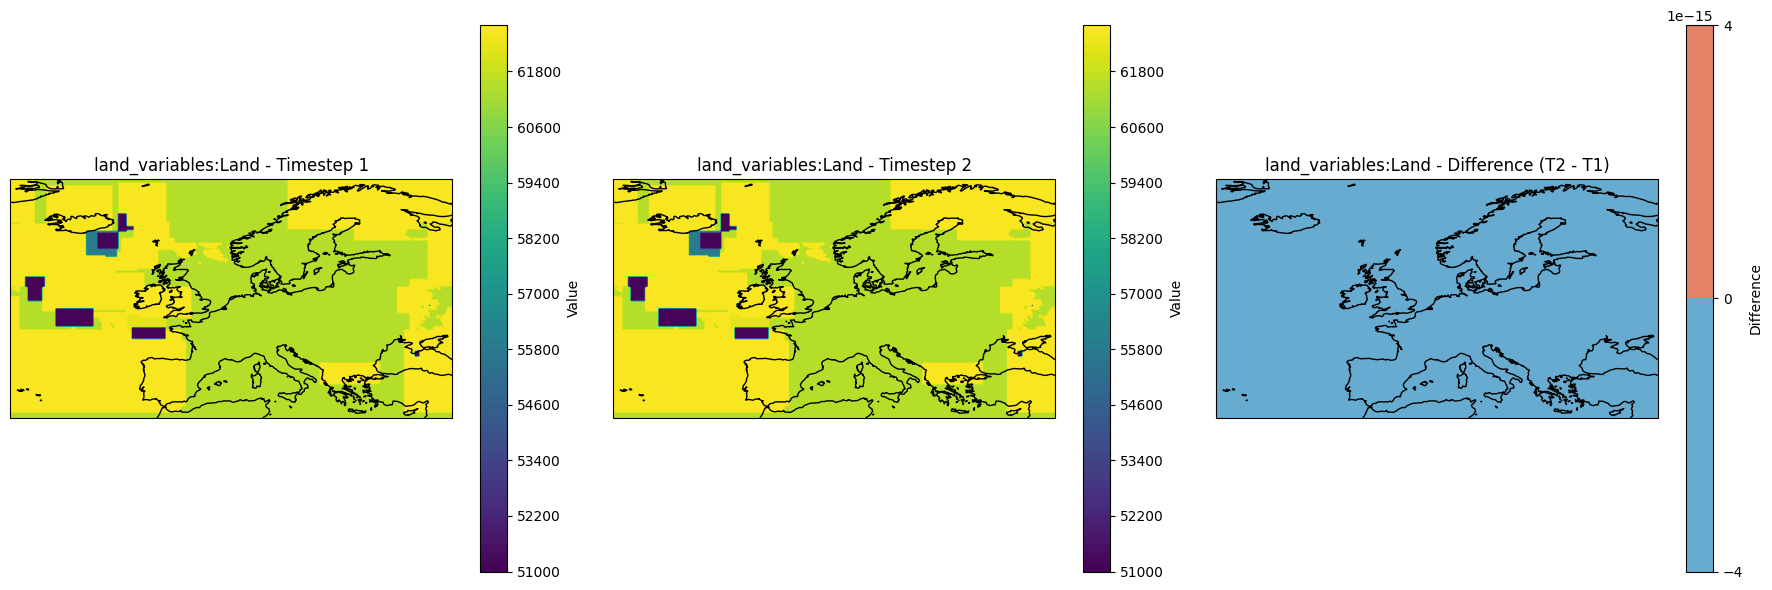

Plotting land_variables:NDVI with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


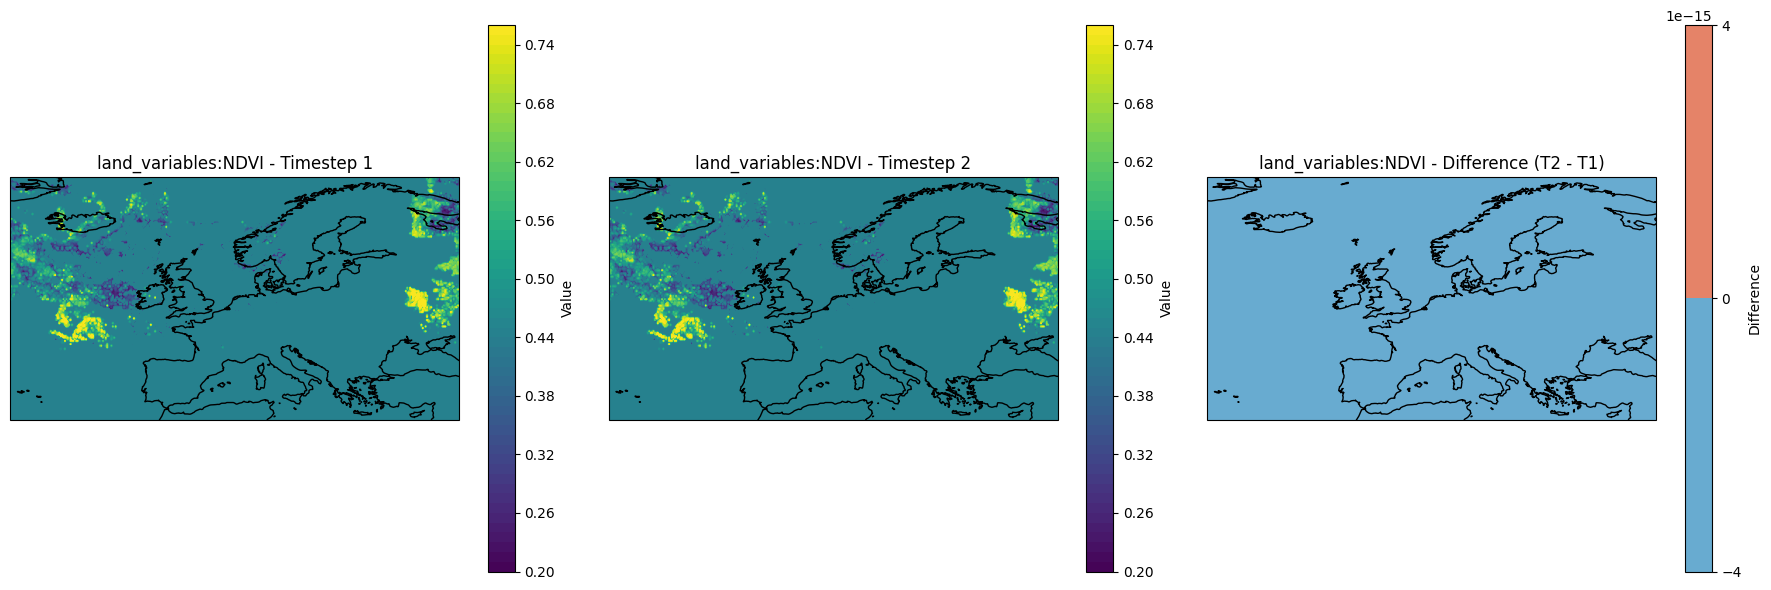

Plotting agriculture_variables:AgricultureLand with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


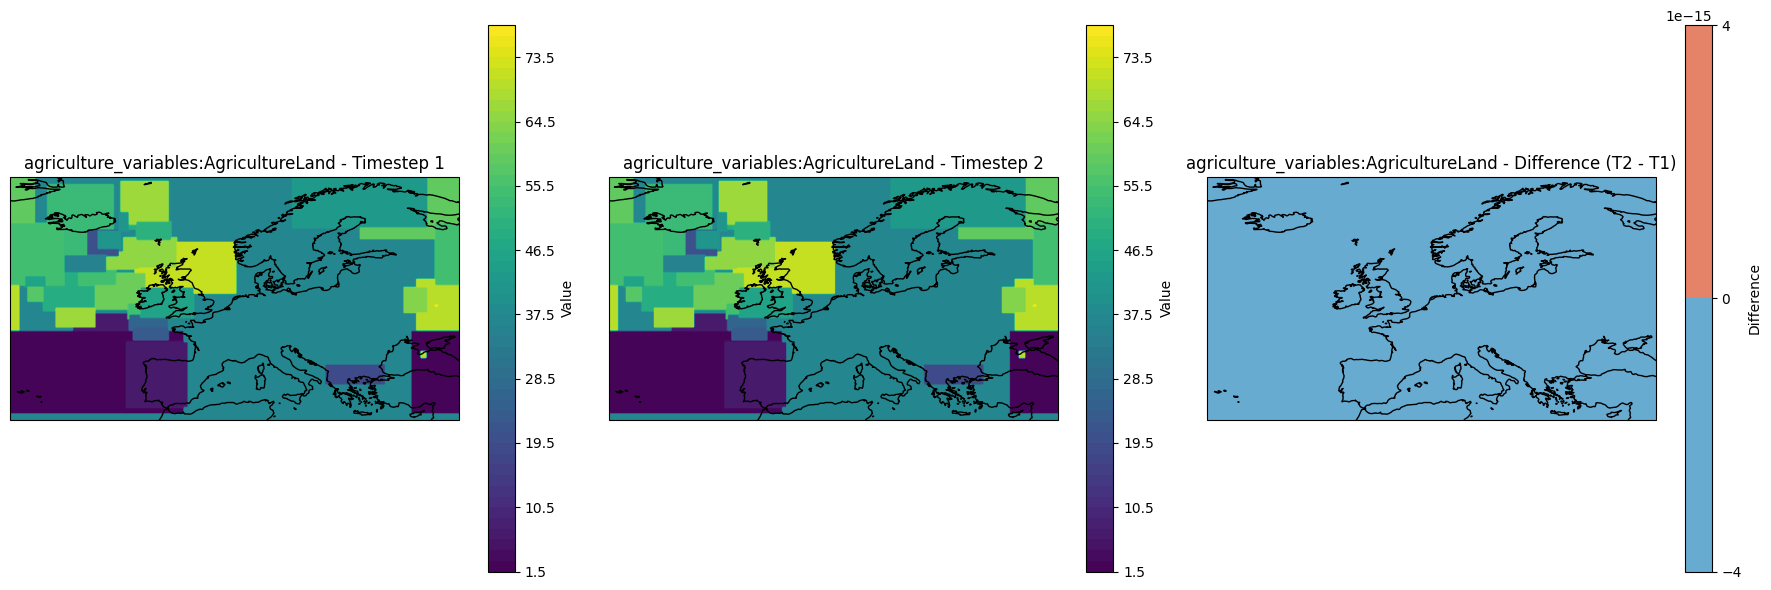

Plotting agriculture_variables:AgricultureIrrLand with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


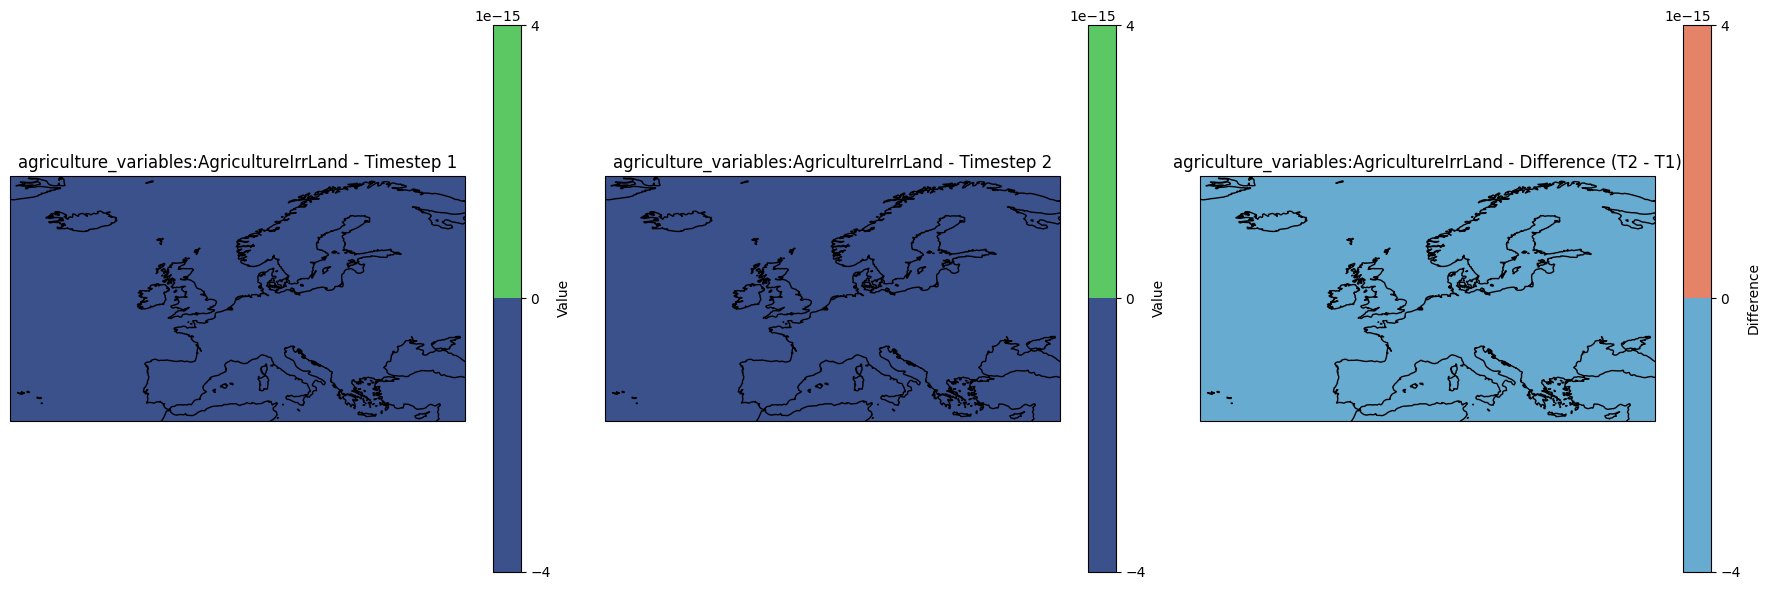

Plotting agriculture_variables:ArableLand with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


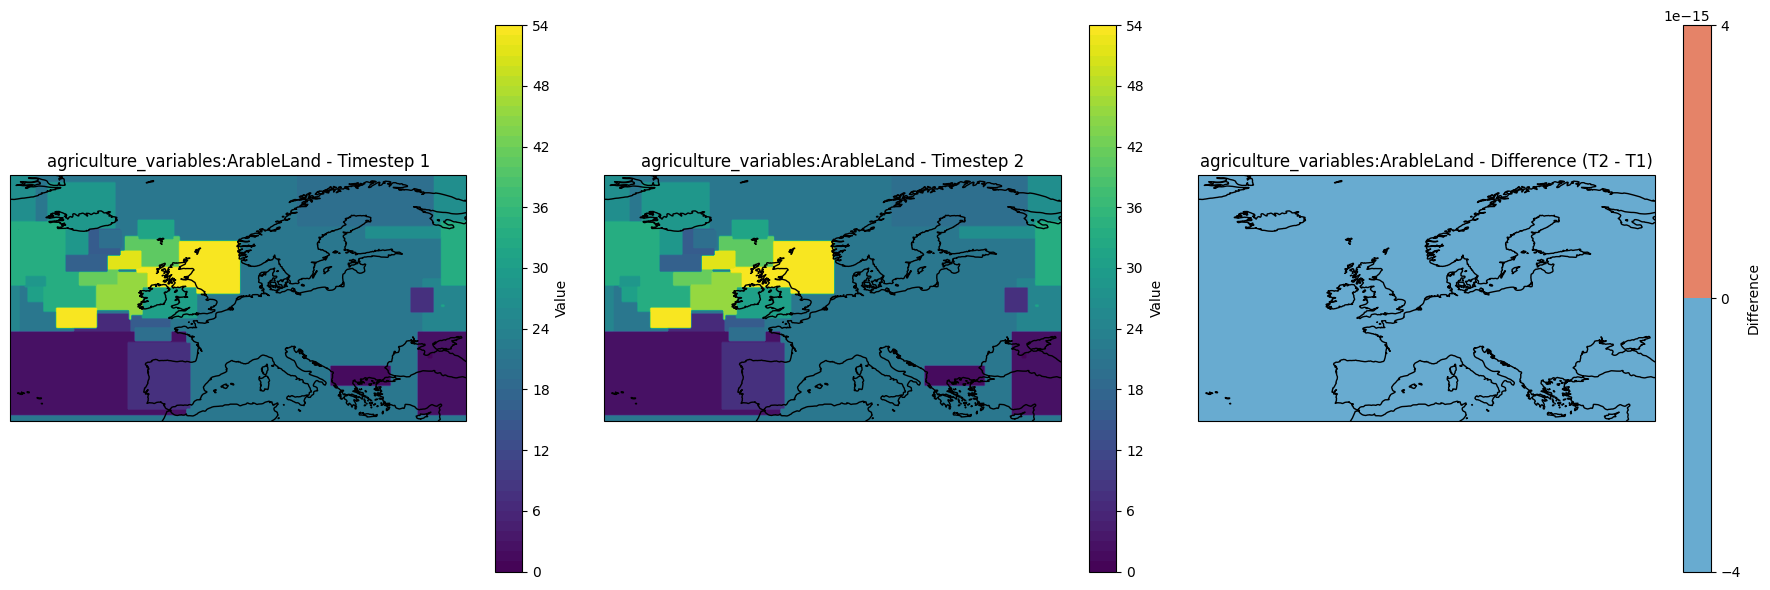

Plotting agriculture_variables:Cropland with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


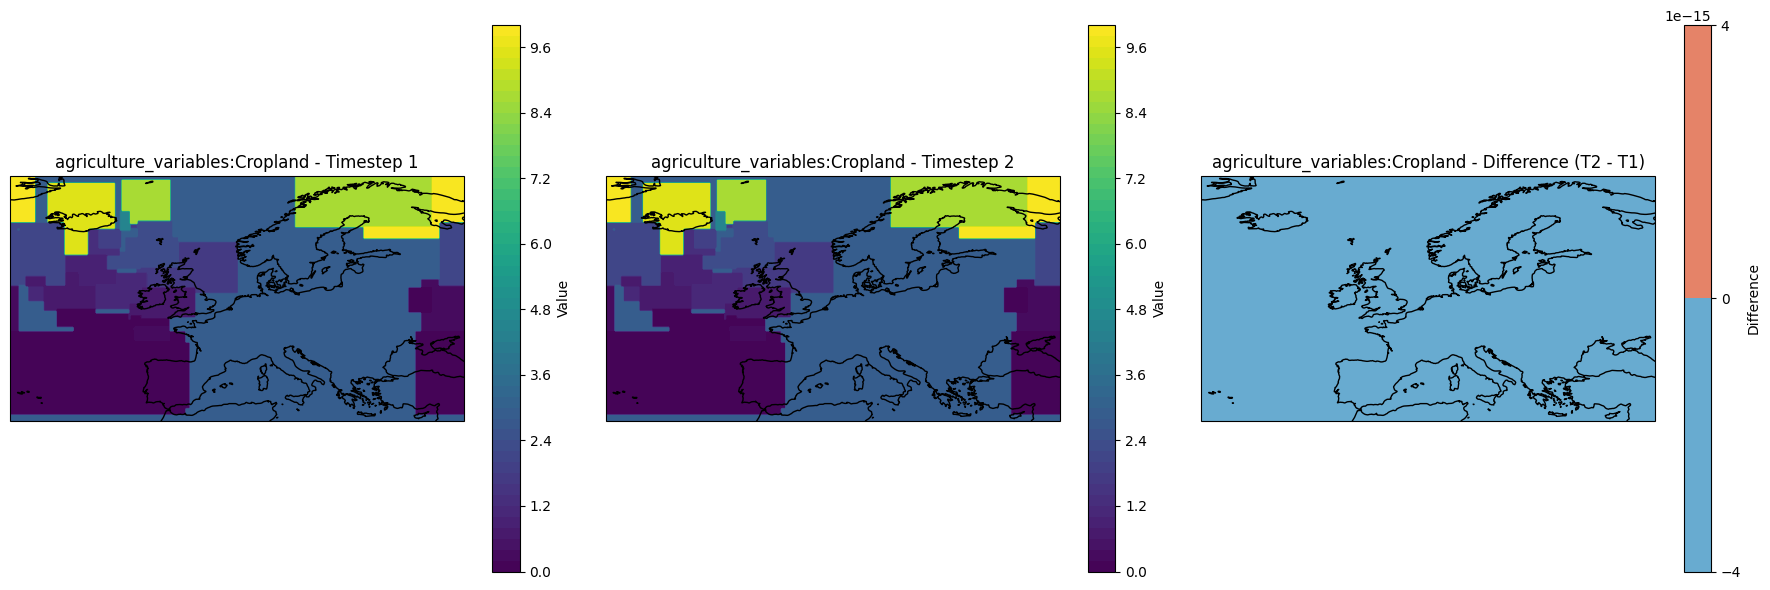

Plotting forest_variables:Forest with shape torch.Size([1, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


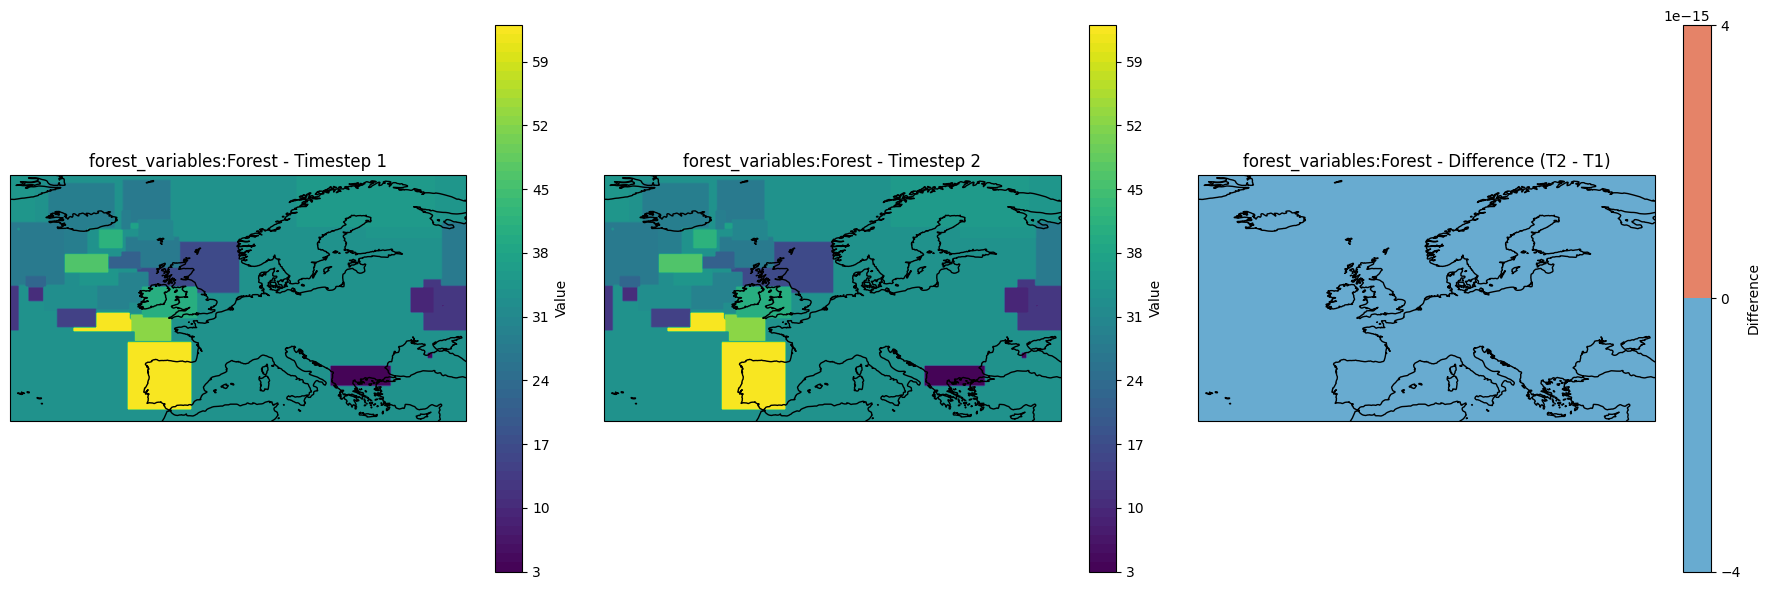

Plotting species_variables:Distribution with shape torch.Size([1, 2, 2, 152, 320])
Using fixed coordinate grid:
Latitude range: 34.25 to 72.0
Longitude range: -30.0 to 40.0
Meshgrid shapes: Lon: (152, 320) Lat: (152, 320)


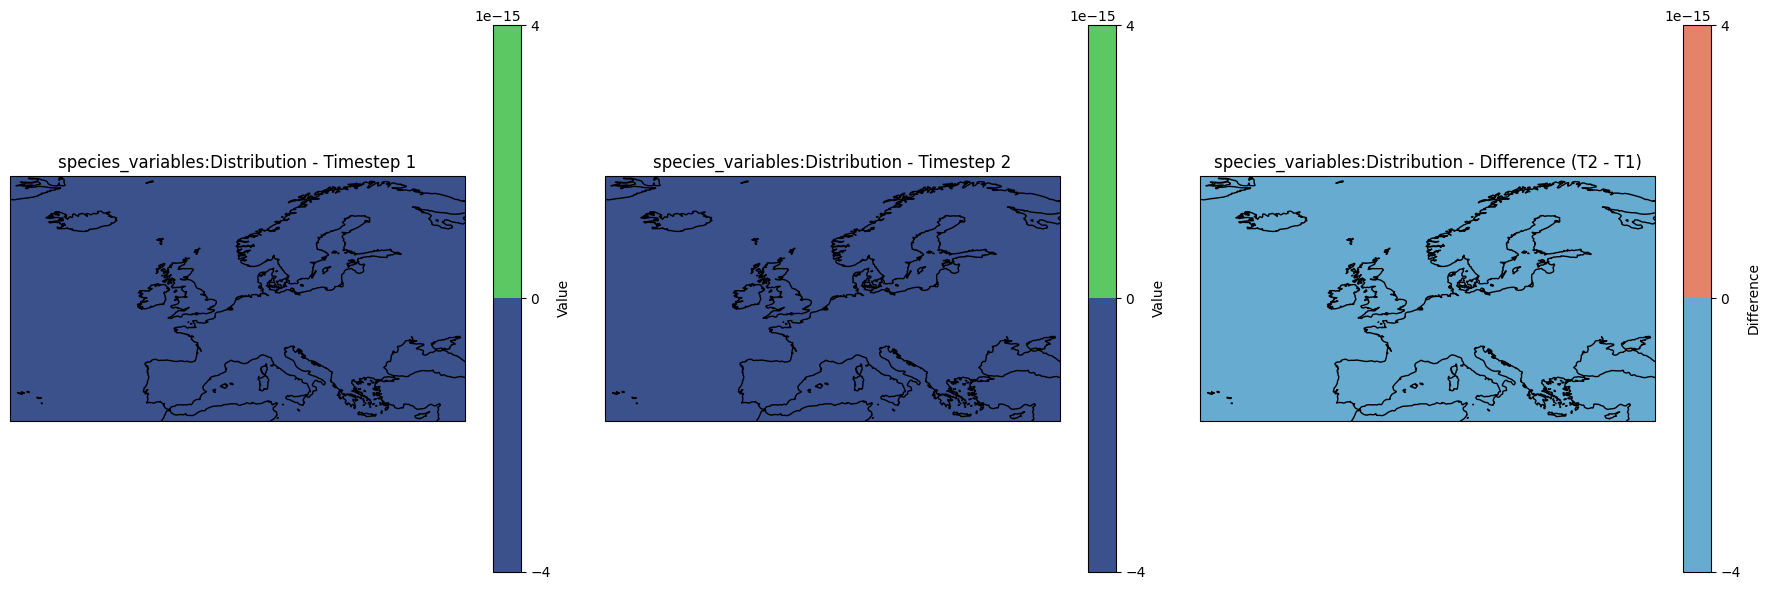

AttributeError: 'Metadata' object has no attribute 'items'

In [20]:
for group_name in groups:
    true_dict = getattr(sample, group_name, {})
    for var_name, tensor in true_dict.items():
        print(f"Plotting {group_name}:{var_name} with shape {tensor.shape}")
        # For 5D tensors with channels, you can choose a channel index.
        if tensor.ndim == 5:
            plot_europe_timesteps_and_difference(f"{group_name}:{var_name}", tensor, channel_idx=0)
        else:
            plot_europe_timesteps_and_difference(f"{group_name}:{var_name}", tensor)